# In this notebook I will devise a strategy for cluster mapping between developmental stages

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony
from numba import jit, float32, int8

import random
np.random.seed(0)
random.seed(0)


import warnings
warnings.filterwarnings('ignore')

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Import data

In [4]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [5]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [6]:
timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , timepoints)
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [7]:

tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [8]:
import pickle

with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [ ]:
spring = pd.read_csv('../embeddings/SPRING_integrated_coordinates.txt', header = None, index_col = 0)
spring.columns = ['x', 'y']
spring.index = counts.index

In [ ]:

    
import pickle
with open('../intermediate_files/louvain_for_lineage_V3', "rb") as f:
    clusters_local_ind = pickle.load( f)

In [10]:
df = pd.concat([pd.Series(['_'.join(['P', str(c)]) for c in clusters], index = clusters.index), clusters_local_ind], axis = 1)
df.columns = ['phenograph', 'louvain']

df = pd.crosstab(df.louvain, df.phenograph)
df.to_csv('frac_lower_resolution.tsv', sep = '\t')


In [11]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import cKDTree
from os import cpu_count

In [15]:
stage_order = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22',
       'st24', 'st27']

In [16]:
stage_order_rev = stage_order[::-1]

In [17]:
n_jobs=24
mnn  = []
knn = 20

def find_neighbors(stage_order, data_df, tp, knn, n_jobs):
    mnn  = []
    stage_order_rev = stage_order[::-1]
    for i in range(len(stage_order)-1):
        print('\t', stage_order_rev[i], '->', stage_order_rev[i+1])

        old = stage_order_rev[i]
        new = stage_order_rev[i+1]


        df1 = data_df.loc[tp[tp == old].index]
        df2 = data_df.loc[tp[tp == new].index]


        mnn.append(cKDTree(df2).query(x=df1, k=knn, n_jobs=n_jobs)[1])
    return mnn
    

In [18]:
def map_neighbor(idx, stage_idx, clusters):
    return clusters[stage_idx[idx]]


In [19]:

def voting(stage_order, mnn, knn,  data_df, tp, clusters, min_cells):
    
    vote_result = {}
    validation = {}
    stage_order_rev = stage_order[::-1]
    for i in range(len(stage_order)-1):
        print('\t', stage_order_rev[i], '->', stage_order_rev[i+1])

        old = stage_order_rev[i]
        new = stage_order_rev[i+1]
        
        neighbors = pd.DataFrame(mnn[i], index = data_df.loc[tp[tp == old].index].index)
        target_idx = data_df.loc[tp[tp == new].index].index

        neighbors = pd.concat([neighbors[i].apply(lambda x: map_neighbor(x, target_idx, clusters)) for i in range(knn)], axis = 1)
        top_clusters = neighbors.mode(axis = 1)
        conf_top_clusters = top_clusters[top_clusters.notna().sum(axis = 1) == 1][0]
        
        mapping = pd.concat([conf_top_clusters, clusters], axis = 1).dropna()
        mapping.columns = ['maps_to', 'cluster']
        mapping.cluster = [str(x)#+'_'+old 
                           for x in mapping.cluster]
        mapping.maps_to = [str(x)#+'_'+new 
                           for x in mapping.maps_to]
        mapping['idx'] = range(len(mapping.maps_to))
        #mapping.maps_to = [int(x) for x in mapping.maps_to]
        mapping = mapping.groupby(['cluster', 'maps_to']).count()
        for_validation = mapping.copy()
        mapping = mapping.sort_values('idx', ascending = False).reset_index().drop_duplicates(subset='cluster', keep='first').set_index('cluster')
        
        vote_result[old] = mapping.loc[mapping.idx > min_cells]
        validation[old] = for_validation
    return vote_result, validation



In [20]:
def anscestor_vote(knn, stage_order, n_jobs,  data_df, timepoints, clusters, min_cells = 1):
    print('Finding {} neighbors in presceding stages'.format(knn))
    mnn = find_neighbors(stage_order, data_df, timepoints, knn, n_jobs)
    
    print('Performing per cell and cluster anscestor voting')
    vote_result = voting(stage_order, mnn, knn,  data_df, timepoints, clusters, min_cells)
    return vote_result

In [21]:
vote_result, validation = anscestor_vote(knn = 1, 
                             stage_order = stage_order,
                             n_jobs = 24,  
                             data_df = data_df, 
                             timepoints = tp, 
                             clusters = clusters_local_ind)#clusters_local_ind)

Finding 1 neighbors in presceding stages
	 st27 -> st24
	 st24 -> st22
	 st22 -> st20
	 st20 -> st18
	 st18 -> st16
	 st16 -> st13
	 st13 -> st12
	 st12 -> st10.5
	 st10.5 -> st08
Performing per cell and cluster anscestor voting
	 st27 -> st24
	 st24 -> st22
	 st22 -> st20
	 st20 -> st18
	 st18 -> st16
	 st16 -> st13
	 st13 -> st12
	 st12 -> st10.5
	 st10.5 -> st08


In [232]:
vote_result_low_res = anscestor_vote(knn = 1, 
                             stage_order = stage_order,
                             n_jobs = 24,  
                             data_df = data_df, 
                             timepoints = tp, 
                             clusters = clusters)#clusters_local_ind)

Finding 1 neighbors in presceding stages
	 st27 -> st24
	 st24 -> st22
	 st22 -> st20
	 st20 -> st18
	 st18 -> st16
	 st16 -> st13
	 st13 -> st12
	 st12 -> st10.5
	 st10.5 -> st08
Performing per cell and cluster anscestor voting
	 st27 -> st24
	 st24 -> st22
	 st22 -> st20
	 st20 -> st18
	 st18 -> st16
	 st16 -> st13
	 st13 -> st12
	 st12 -> st10.5
	 st10.5 -> st08


In [21]:
def hierarchy_pos(G, root=None, width=15., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [22]:
def compute_layout(vote_result):


    tree = [[(x, vote_result[ i].loc[x, 'maps_to']) for x in vote_result[ i].index]  for i in stage_order[1:] ]
    tree = [y for x in tree for y in x] 
    G=nx.Graph()
    G.add_edges_from(tree)
    pos = nx.spring_layout(G, iterations = 1000)
    return G, pos


In [22]:
df = pd.concat(vote_result, axis = 0).reset_index()[['maps_to','cluster']]
df.columns = ['to', 'from']
df.to_csv('links_louvain_for_lineage.tsv', sep = '\t')

In [57]:
lis = list()
for i in validation.keys():
    lis.append(validation[i])
    
lis = pd.concat(lis).reset_index()

lis.pivot(index = 'maps_to', columns = 'cluster', values = 'idx').to_csv('lineage_mapping_confidence.tsv', sep = '\t')

In [47]:
def validate_voting(validation, stage_order):
    for idx, i in enumerate(stage_order[1:]):
        print(stage_order[idx], stage_order[idx+1])
        df = validation[i].reset_index()
        df = df.pivot(index='cluster', columns='maps_to', values='idx').replace(np.NaN, 0)
        if len(df.columns ) > 1:
            fg = sns.clustermap(df.div(df.sum(axis=1), axis = 0), figsize=(5,5))
            fg.ax_heatmap.set_xlabel('Stage : {}'.format(stage_order[idx]))
            fg.ax_heatmap.set_ylabel('Stage : {}'.format(stage_order[idx+1]))
        else:
            fg = sns.heatmap(df.div(df.sum(axis=1), axis = 0), vmin = 0, vmax = 1)
            fg.set(xlabel='Stage : {}'.format(stage_order[idx]), ylabel='Stage : {}'.format(stage_order[idx+1]))
        plt.savefig('Figures/mapping_confidence{}_to_{}.pdf'.format(stage_order[idx+1].replace('.', '_'), 
                                                                             stage_order[idx].replace('.', '_')))
        plt.show()
            

st08 st10.5


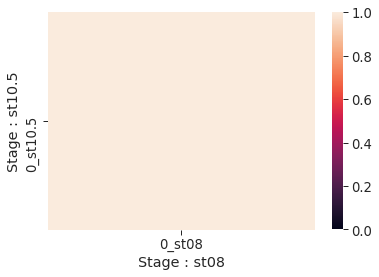

st10.5 st12


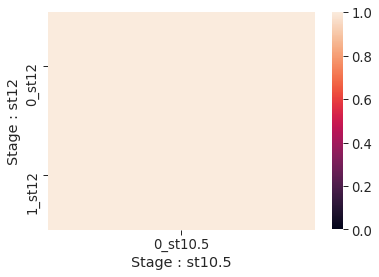

st12 st13


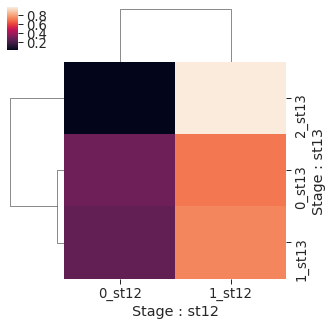

st13 st16


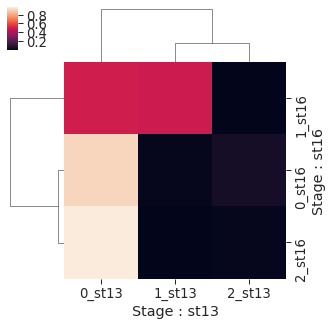

st16 st18


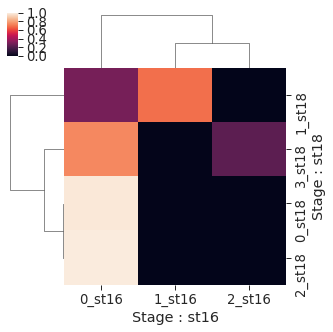

st18 st20


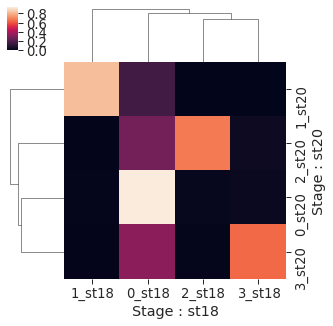

st20 st22


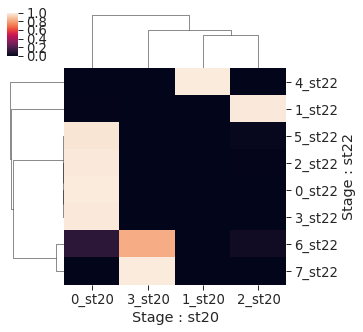

st22 st24


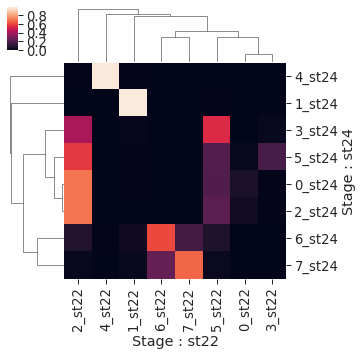

st24 st27


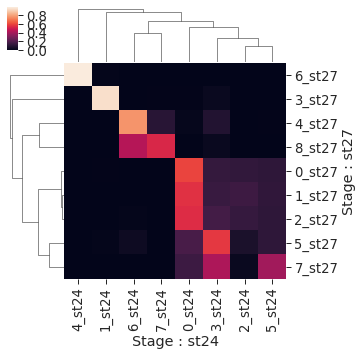

In [48]:
validate_voting(validation, stage_order)

In [24]:
Ns =clusters_local_ind.value_counts()
Ns = pd.Series([' = '.join(['N', str(i)]) for i in Ns], index = Ns.index)
Ns.to_csv('louvain_clust_size.tsv', sep = '\t')

In [28]:
cc_phase = pd.read_csv('../Old_lineage_map_files/cc_phase.tsv', sep = '\t', index_col = 0, header = None)
cc_phase.columns = ['phase']

In [29]:
cc = pd.concat([cc_phase, clusters_local_ind], axis = 1)

In [30]:
cc.columns = ['phase', 'group']
cc = pd.crosstab( cc.group, cc.phase)

In [73]:
test = pd.DataFrame(counts.sum(axis = 1))
test['group'] = clusters_local_ind
cou = test.groupby('group').mean()
cou.columns = ['Mean Counts']

In [77]:
test = pd.DataFrame((counts>0).sum(axis = 1))
test['group'] = clusters_local_ind
gen = test.groupby('group').mean()
gen.columns = ['Mean Genes detected']

In [75]:
Ns =pd.DataFrame(clusters_local_ind.value_counts())
Ns.columns = ['N cells']

In [31]:
cc.to_csv('cc_louvain_freq.tsv', sep = '\t')

In [79]:
pd.concat([Ns, cc, cou, gen], axis = 1).to_csv('louvain_mapping_stats.tsv', sep = '\t')

In [25]:
norm_df['group'] = clusters_local_ind
norm_df.groupby('group').mean().to_csv('group_expression.tsv', sep = '\t')